In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array, collatev2
import winsound
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck

In [2]:
import logging
logger = logging.getLogger('andy')
fh = logging.FileHandler('andy.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 5)

In [4]:
data = data[data['has_microbleed_slice'] == 1].reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,1,1
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,1,1
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,1,1
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,1,1
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,15,1,1
...,...,...,...,...,...
359,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1
360,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,26,1,1
361,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,24,1,1
362,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1


In [5]:
ch1 = ds.load_raw_mri(1)
data = data[data.mri.isin(ch1)]
data.shape

(45, 5)

In [6]:
transform = NiftiToTensorTransform(target_shape = (300, 300), rpn_mode=True) # Hanggang dito lang kaya ng GPU mem ko

cases = data.mri
masks = data.masks
target = data.target

In [7]:
dataset = VALDODataset(
    cases=cases,
    masks=masks,
    target=target,
    transform=transform,
    normalization=z_score_normalization,
)

In [8]:
dataset.__len__()

45

In [9]:
dloader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=10,
    collate_fn=collatev2,
)

In [10]:
# for i in range(dloader.__sizeof__()):
#     print(dloader.dataset[i][2])

In [11]:
# all_with_bbox = []
# for i in range(dloader.dataset[1][1].shape[0]):
#     if 0 in dloader.dataset[1][1][i][0][0]:
#         continue
#     else:
#         all_with_bbox.append((dloader.dataset[1][1][i][0][0])/300)


In [12]:
# sample = torch.stack(all_with_bbox)
# print(sample)

### Config for fitter

In [13]:
from project.model import RPN

config = {
    'model': RPN(
        input_dim=2500,
        output_dim=4,
        image_size=300
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 20,
    # 'loss': nn.SmoothL1Loss(),
    'loss': nn.MSELoss(),
    'lr': 0.00001
}

1369


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Sample trial

In [14]:
model = config['model']

In [15]:
# model.embedder.load_state_dict(torch.load('Encoder_weights_211024184155.pt'))

### Fitter

In [16]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                num_slices = slices.shape[0]
                # x = slices.view(num_slices, 1, -1).float().to(self.device)
                # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                # masks = masks.view(num_slices, 1, -1).float().to(self.device)
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)

                for i in range(masks.shape[0]):
                    masks[i][0] = masks[i][0] / 300
                    if any(num < 0 for num in masks[i][0]):
                        print(masks[i][0])
                # print(masks.shape)
                # print(masks)
                # break
                y = self.model(x, target)
                # logger.info(f'MEMORY after X, Y, T to device\t{memcheck()}')
                logger.info(f'Prediction: {y * 300}, Original: {masks[target] * 300}')
                Y.append(y)
                T.append(masks[target])
                # memcheck()
                # del x, y, masks, slices
                # torch.cuda.empty_cache()
                # memcheck()
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += len(batch)
            if counter % 100 == 0:
                logger.info(f'Progress:\t{counter}/{len(dataset)}')
                logger.info(f'Current error:\t{losses}')
            loss_history.append(losses.detach().cpu().numpy())
            
            # del losses, Y, T
            # torch.cuda.empty_cache()
            # logger.info(f'MEMORY after CLEARING MEMORY\t{memcheck()}')
        
        return loss_history

In [17]:
fitter = RPNFitter(config)

### Training

In [18]:
hist = fitter.fit(dloader, dloader)

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [19]:
winsound.Beep(500, 500)

tensor(0.0943)

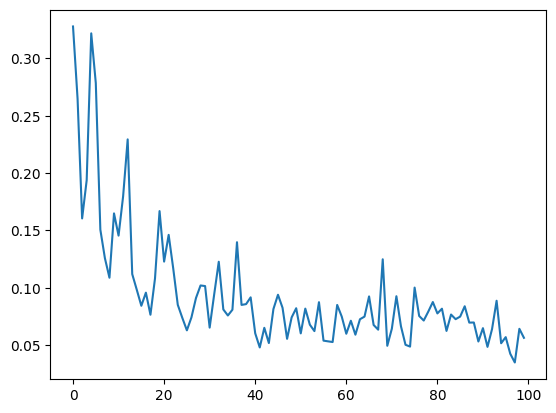

In [20]:
import seaborn as sns
import numpy as np

sns.lineplot(torch.tensor(np.array(hist)).view(-1))
torch.tensor(np.array(hist)).mean()

### Line Plot by epoch mean

tensor([0.2537, 0.1657, 0.1529, 0.1063, 0.1089, 0.0863, 0.0878, 0.0966, 0.0613,
        0.0776, 0.0719, 0.0639, 0.0675, 0.0795, 0.0644, 0.0827, 0.0742, 0.0702,
        0.0635, 0.0509])


<Axes: >

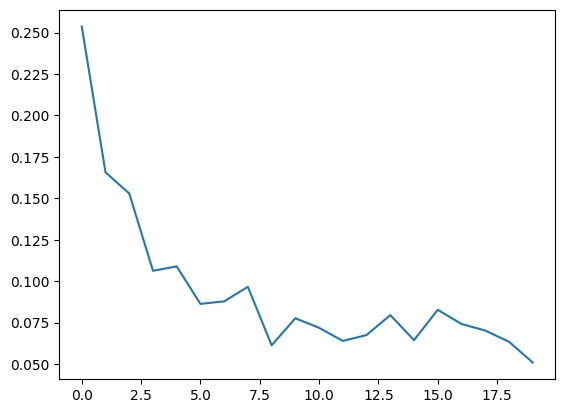

In [21]:
print(torch.tensor(np.array(hist)).mean(1))
sns.lineplot(torch.tensor(np.array(hist)).mean(1))

In [22]:
torch.tensor(np.array(hist)).view(-1)

tensor([0.3278, 0.2648, 0.1604, 0.1937, 0.3218, 0.2785, 0.1507, 0.1258, 0.1087,
        0.1648, 0.1455, 0.1797, 0.2294, 0.1119, 0.0982, 0.0843, 0.0957, 0.0765,
        0.1081, 0.1668, 0.1228, 0.1461, 0.1169, 0.0851, 0.0737, 0.0629, 0.0741,
        0.0911, 0.1020, 0.1015, 0.0652, 0.0944, 0.1227, 0.0811, 0.0758, 0.0808,
        0.1397, 0.0850, 0.0857, 0.0916, 0.0603, 0.0479, 0.0650, 0.0518, 0.0814,
        0.0939, 0.0825, 0.0554, 0.0741, 0.0821, 0.0602, 0.0818, 0.0678, 0.0622,
        0.0874, 0.0539, 0.0532, 0.0527, 0.0850, 0.0749, 0.0599, 0.0712, 0.0591,
        0.0725, 0.0748, 0.0925, 0.0675, 0.0634, 0.1248, 0.0494, 0.0643, 0.0926,
        0.0664, 0.0503, 0.0487, 0.1001, 0.0754, 0.0714, 0.0792, 0.0875, 0.0776,
        0.0817, 0.0623, 0.0766, 0.0726, 0.0748, 0.0839, 0.0696, 0.0697, 0.0531,
        0.0648, 0.0484, 0.0639, 0.0887, 0.0516, 0.0569, 0.0424, 0.0348, 0.0642,
        0.0563])

# Summary

Performance of self-made embedder is a bit better compared to the pretrained embedder. Might work better if self-made embedder is also pretrained

### Next goals
- train embedder with an autoencoder setup

# Trial

In [23]:
model = fitter.model

In [24]:
sample = next(enumerate(dloader))

In [25]:
slices, masks, target, case = sample[1][1]

In [26]:
masks[target]

tensor([[[157.0312, 196.2891, 170.5078, 209.7656]]], dtype=torch.float64)

In [27]:
num_slices = slices.shape[0]
num_slices

35

In [28]:
x = slices.squeeze(1).float().to(device)
T = masks.squeeze(1).float().to(device)

In [29]:
y = model(x, target)

In [30]:
fitter.loss(y, T[target])

tensor(33830.6172, device='cuda:0', grad_fn=<MseLossBackward0>)

In [31]:
y

tensor([[0.5501, 0.4333, 0.3707, 1.1271]], device='cuda:0',
       grad_fn=<EluBackward0>)